In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from pathlib import Path

import shamans.utils.eval_utils as eval

In [22]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False, encoding='utf-8-sig')
    return combined_csv

In [23]:
# load data
exp_id = 5
path_to_results = Path('results/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)

In [24]:
# compute accuracy and recall for each doas estimated by each method within a threshold of 10 degrees

def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

exp_df['ang_error'] = calc_ae(
    np.rad2deg(exp_df['doas_est_az']), 
    np.rad2deg(exp_df['doas_ref_az'])
)

ang_error_threshold_choices = [15]

# compute accuracy and recall based on the frame id as in DCASE Task 3
unique_frame_ids = exp_df['frame_id'].unique()
unique_method_ids = exp_df['method_id'].unique()

df_thresholds = pd.DataFrame()

for frame_id in tqdm(unique_frame_ids, desc='frame'):
    df_frame = exp_df[exp_df['frame_id'] == frame_id]
    
    for method_id in unique_method_ids:
        df_method = df_frame[df_frame['method_id'] == method_id]    
                
        assert len(df_method) == np.unique(df_method['doas_est_az']).shape[0] == np.unique(df_method['n_sources'])
            
        # accuracy and mean error
        for thr in ang_error_threshold_choices:
            
            accuracy = np.sum(df_method['ang_error'] <= thr) / len(df_method)
            error = np.mean(df_method[df_method['ang_error'] <= thr]['ang_error'])

            df_ = pd.DataFrame({
                "frame_id": frame_id,
                "method_id": method_id,
                "accuracy": accuracy,
                "mean_error": error,
                "threshold": thr
            }, index=[0])
            df_thresholds = pd.concat([df_thresholds, df_], ignore_index=True)

frame: 100%|██████████| 12/12 [00:00<00:00, 19.60it/s]


In [25]:
df_merge = exp_df.merge(df_thresholds, on=['frame_id', 'method_id'])

In [26]:
# n_sources_choice = [1]
# source_type_choices = ['speech']
# snr_choices = np.arange(-30, 31, 10).tolist()
# noise_type_choices = ['awgn', 'alpha-1.2', 'alpha-0.8']
# sound_duration_choices = [0.5]
# add_reverb_choices = [False]

df_merge = df_merge.assign(sv_model=df_merge['sv_method'] + '_' + df_merge['nObs'].astype(str))
df_merge = df_merge.assign(loc_algo=df_merge['loc_method'].str[:3])

print(df_merge['sv_method'].unique())
print(df_merge['sv_model'].unique())
print(df_merge['noise_type'].unique())
print(df_merge['n_sources'].unique())
print(df_merge['snr'].unique())
print(df_merge['duration'].unique())
print(df_merge['rt60'].unique())
print(df_merge['loc_method'].unique())
print(df_merge['source_type'].unique())


idx = df_merge['loc_method'].str.startswith('alpha')
df_merge.loc[idx, 'alpha_method'] = df_merge.loc[idx, 'loc_method'].apply(lambda x: float(x.split('_')[0].split('-')[-1]))
df_merge.loc[idx, 'alpha_scene'] = df_merge.loc[idx, 'source_type'].apply(lambda x: float(x.split('-')[-1]))


['ref' 'alg' 'gp-steerer']
['ref_8' 'alg_8' 'gp-steerer_8' 'gp-steerer_16' 'gp-steerer_32'
 'gp-steerer_64' 'gp-steerer_128']
['awgn']
[3]
[20]
[1.]
[0.123]
['alpha-1.6_beta-1_eps-1E-3_iter-500' 'alpha-0.8_beta-1_eps-1E-3_iter-500'
 'alpha-0.4_beta-1_eps-1E-3_iter-500' 'alpha-0.1_beta-1_eps-1E-3_iter-500'
 'alpha-2.0_beta-1_eps-1E-3_iter-500' 'alpha-2.0_beta-2_eps-1E-3_iter-500'
 'alpha-1.2_beta-1_eps-1E-3_iter-500' 'music_s-3' 'srp_phat']
['alpha-0.1' 'alpha-0.4' 'alpha-0.8' 'alpha-1.2' 'alpha-1.6' 'alpha-2.0']


In [27]:
best_seed = 666
# rename ref_8 and alg_6 to ref and alg
df_merge['sv_model'] = df_merge['sv_model'].str.replace('ref_8', 'ref')
df_merge['sv_model'] = df_merge['sv_model'].str.replace('alg_8', 'alg')
df_merge.loc[df_merge['sv_model'] == 'ref', 'seed'] = 666
df_merge.loc[df_merge['sv_model'] == 'alg', 'seed'] = 666

<Axes: xlabel='alpha_scene', ylabel='alpha_method'>

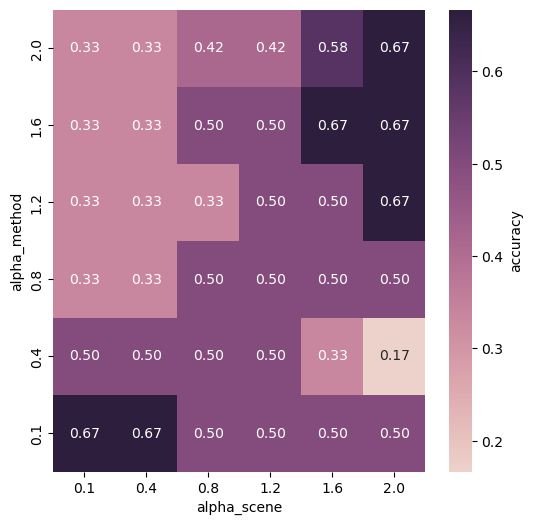

In [37]:
n_max_sources = np.max(df_merge['n_sources'])
loc_methods = np.unique(df_merge['loc_method'])
sv_methods = np.unique(df_merge['sv_method'])
rt60_choices = np.unique(df_merge['rt60'])

df_merge['loc_method_simple'] = df_merge['loc_method'].apply(lambda x: x.split('-')[0])
    
df_ = df_merge[
    (df_merge['seed'] == best_seed)
    & (df_merge['threshold'] == thr)
    & (df_merge['n_sources'] == 3)
    & (df_merge['record_id'] == 's0')
    & (df_merge['rt60'] == 0.123)
    & (df_merge['sv_model'] == 'gp-steerer_64')
]

fig, axarr = plt.subplots(1, 1, figsize=(6, 6))
heat = df_.pivot_table(
    index='alpha_method', 
    columns='alpha_scene', 
    values='accuracy', 
    aggfunc='mean'
)
heat.sort_index(level=0, ascending=False, inplace=True)
sns.heatmap(heat, ax=axarr, annot=True, fmt=".2f", cbar_kws={'label': 'accuracy'}, 
            cmap=sns.cubehelix_palette(as_cmap=True))
